## Exploratory Analysis on Taxi Transactions in Specific Locations in New York City

Accurate prediction of taxi demand can help hailing company allocate cars, drivers and to set prices accordingly. This notebook walks through how to look for patterns from previous taxi transaction data. The result of this exploratory analysis can be applied to predict future number of transactions. The taxi trip record data from New York City Taxi and Limousine Commission (TLC) (https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page) are used for the exploratory analysis.

In [1]:
from IPython.display import display, Markdown
import dask.dataframe as dd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import random

## 1. Load Data
Transaction records are preprocessed (data extraction, cleansing, transformation etc.) using dask, a library for manipulating dataframes optimized for speed with parallel computing. Records from 2015 to 2021, 60 million rows in total, were used for the demonstration.

In [2]:
Records = dd.read_parquet('green_tripdata_2015-01.parquet')
Records.columns

for y in range(2015, 2022):
    for m in ['01', '02', '03','04','05','06',
              '07', '08', '09','10','11','12']:
        if y == 2015 and m == '01':
            pass
        else:
            df = dd.read_parquet('green_tripdata_'+str(y)+'-'+ m + '.parquet')        
            Records = dd.multi.concat([Records, df])
        

In [3]:
Records.shape[0].compute(), Records.shape[1]

(65359999, 20)

## 2. Yearly and Monthly Trend of Taxi Transactions
To see if taxi transactions fluctuate regularly every month or year, transaction records were aggregated by year and month to see if there were any trends from 2015 to 2021.

In [4]:
Records['Yr'] = Records['lpep_pickup_datetime'].dt.year
Records['Month'] = Records['lpep_pickup_datetime'].dt.month

In [5]:
AggYM = Records.groupby(['Yr','Month']).PULocationID.count().reset_index().compute()

In [6]:
# exclude unreasonable records after parsing datetime
AggYM_Clean = AggYM[AggYM['Yr'].isin([2015,2016,2017,2018,2019,2020,2021])].copy()

#Add column of demand in million
AggYM_Clean.rename(columns={"PULocationID": "# Transactions"}, inplace = True) 
AggYM_Clean['# Transaction (M)'] = AggYM_Clean['# Transactions']/1000000

AggYM_Clean.head()

,Yr,Month,# Transactions,# Transaction (M)
0,2015,1,1508493,1.508493
1,2015,2,1574830,1.574830
2,2015,3,1722574,1.722574
3,2015,4,1664394,1.664394
4,2015,5,1786848,1.786848


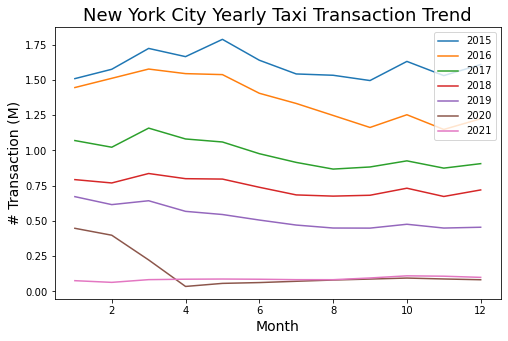

In [7]:
AggYM_Clean_piv = AggYM_Clean.pivot(index='Month', columns='Yr', values='# Transaction (M)')

#Draw plot of taxi transaction yearly and monthly trend in New York City
AggYM_Clean_piv.plot(figsize = (8,5))
plt.title('New York City Yearly Taxi Transaction Trend', fontsize=18)
plt.xlabel("Month", fontsize=14)
plt.ylabel("# Transaction (M)", fontsize=14)
plt.legend(loc='best')
plt.show()
#plt.savefig('New York City Taxi Demand Trend 2015-2022.jpg', dpi = 70, bbox_inches='tight')

From the above figure, we can see the following:
1. From 2015 to 2022, annual taxi transaction numbers decrease.
2. There exists monthly trend of of taxi transaction (e.g. more transactions in March, May, less in September). The trend dissappeared almost completely in 2020 and 2021, presumably due to the COVID-19 pandemic.

From the aggregation below, we can tell that from 2015 to 2019, the number of taxi transactions decreases by 15~30 percent every year.

In [8]:
AggY = Records.groupby(['Yr']).PULocationID.count().reset_index().compute()
AggY_Clean = AggY[AggY['Yr'].isin([2015,2016,2017,2018,2019,2020,2021])].copy()
AggY_Clean.rename(columns={"PULocationID": "# Transactions"}, inplace = True) 
AggY_Clean

,Yr,# Transactions
0,2015,19233765
1,2016,16385541
2,2017,11736906
7,2018,8899314
9,2019,6300814
10,2020,1734166
15,2021,1068726


## 3. Taxi Transaction in Different Buroughs
There are five buroughs in New York city, Brooklyn, Queens, Bronx, Manhattan and Staten Island, as shown below (photo from New York City Taxi and Limousine Commission). In every burough, there are numerous taxi zones (around 0.5 ~ 2 * 0.5 ~ 2 miles in area). Our goal is to predict number of transactions in a future time point in different taxi zone.

Here, we first examine trends of transaction numbers in different buroughs.

<img src="Buroughs.jpg">

In [9]:
# load taxi zone map
TaxiZoneMap = dd.read_csv('taxi+_zone_lookup.csv')
TaxiZoneMap.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [10]:
RecordsPickup = Records[['lpep_pickup_datetime', 'PULocationID', 'Yr', 'Month']]
RecordsPickupMapped = RecordsPickup.merge(TaxiZoneMap, left_on = 'PULocationID', right_on = 'LocationID', how = 'inner')
RecordsPickupMapped.head()

,lpep_pickup_datetime,PULocationID,Yr,Month,LocationID,Borough,Zone,service_zone
0,2015-01-01 00:31:10,255,2015,1,255,Brooklyn,Williamsburg (North Side),Boro Zone
1,2015-01-01 00:17:10,255,2015,1,255,Brooklyn,Williamsburg (North Side),Boro Zone
2,2015-01-01 00:08:03,255,2015,1,255,Brooklyn,Williamsburg (North Side),Boro Zone
3,2015-01-01 00:28:06,255,2015,1,255,Brooklyn,Williamsburg (North Side),Boro Zone
4,2015-01-01 00:33:19,255,2015,1,255,Brooklyn,Williamsburg (North Side),Boro Zone


<table><tr>
<td><img src="Bronx.jpg" height="200" width="300"/> </td>
<td><img src="Brooklyn.jpg" height="200" width="300"/> </td>
<td><img src="Manhattan.jpg" height="200" width="300"/> </td>
</tr></table>

<table><tr>
<td><img src="Queens.jpg" height="200" width="300"/> </td>
<td><img src="StatenIsland.jpg" height="200" width="300"/> </td>
</tr></table>

In [11]:
AggYMB = RecordsPickupMapped.groupby(['Yr','Month','Borough']).PULocationID.count().reset_index().compute()
# exclude unreasonable records after parsing datetime
AggYMB_Clean = AggYMB[AggYMB['Yr'].isin([2015,2016,2017,2018,2019,2020,2021])].copy()
AggYMB_Clean.rename(columns={"PULocationID": "# Transactions"}, inplace = True) 
#Add column of demand in million
AggYMB_Clean['# Transaction (K)'] = AggYMB_Clean['# Transactions']/1000
AggYMB_Clean.head()

,Yr,Month,Borough,# Transactions,# Transaction (K)
0,2015,1,Bronx,91712,91.712
1,2015,1,Brooklyn,569897,569.897
2,2015,1,EWR,33,0.033
3,2015,1,Manhattan,430384,430.384
4,2015,1,Queens,412912,412.912


In [12]:
for b in ['Bronx','Brooklyn','Manhattan','Queens', 'Staten Island']:
    AggYMB_Borough =AggYMB_Clean[AggYMB_Clean['Borough']==b]
    
    AggYMB_Borough_piv = AggYMB_Borough.pivot(index='Month', columns='Yr', values='# Transaction (K)')
    
    #Draw plot
    #AggYMB_Borough_piv.plot(figsize = (8,5))
    #plt.title(b + ' Yearly Taxi Transaction Trend', fontsize=18)
    #plt.xlabel("Month", fontsize=14)
    #plt.ylabel("# Transaction (K)", fontsize=14)
    #plt.legend(loc='best')
    #plt.show()
    #plt.savefig(b + ' Transaction Trend 2015-2022.jpg', dpi = 70, bbox_inches='tight')

<table><tr>
<td><img src="New York City Taxi Demand Trend 2015-2022.jpg" height="200" width="300"/> </td>
<td><img src="Brooklyn Transaction Trend 2015-2022.jpg" height="200" width="300"/> </td>
<td><img src="Manhattan Transaction Trend 2015-2022.jpg" height="200" width="300"/> </td>
</tr></table>

<table><tr>
<td><img src="Queens Transaction Trend 2015-2022.jpg" height="200" width="300"/> </td>
<td><img src="Bronx Transaction Trend 2015-2022.jpg" height="200" width="300"/> </td>
<td><img src="Staten Island Transaction Trend 2015-2022.jpg" height="200" width="300"/> </td>
</tr></table>

From the monthly transaction trends shown above, we can see the following:
1. Number of transactions in Brooklyn, Manhattan, Queens showed similar trend to the overall trend of New York City (e.g. more transactions in March, May, less in September). 
2. The trend in Bronx is less clear. As for Staten Island, there seems to be no monthly trend of transaction. 
3. The total amount of number transaction in Staten Island is far less than that of other buroughs in New York City.

## 4. Taxi Transactions in Different Taxi Zones
Our goal is to predict number of taxi transaction in each zone with fine temperal resolutions. Here, we first take a look at the distribution of number of transactions in different zones. Since number of transactions in zones vary, we categorize zones into four tiers according to average annual number of taxi transactions. The more transactions in a given period, the higher the importance that the zone is to taxi companies.

In [13]:
AggLoc = RecordsPickupMapped.groupby(['PULocationID', 'Borough']).lpep_pickup_datetime.count().reset_index().compute()
AggLoc.rename(columns={"lpep_pickup_datetime": "# Transactions"}, inplace = True)  
AggLoc['Avg # Transactions (yr)'] = AggLoc['# Transactions']/7
AggLoc['Avg # Transactions (yr)'] = AggLoc['Avg # Transactions (yr)'].round(1)
AggLoc['Avg # Transactions (day)'] = AggLoc['Avg # Transactions (yr)']/365
AggLoc['Avg # Transactions (day)'] = AggLoc['Avg # Transactions (day)'].round(1)

Taxi zones were categorized into four tiers based on the following rules. <br>
Tier 1 zones: average annual taxi transaction > 100,000, or daily transaction > 250 (approximately). <br>
Tier 2 zones: average annual taxi transaction > 20,000, or daily transaction > 50 (approximately). <br>
Tier 3 zones: average annual taxi transaction > 10,000, or daily transaction > 25 (approximately). <br>
Tier 4 zones: average annual taxi transaction < 10,000, or daily transaction < 25 (approximately). <br>

In [14]:
def LabelZoneTier(NumYrTXR):
    if NumYrTXR > 100000:
        return 1
    elif NumYrTXR > 20000:
        return 2    
    elif NumYrTXR > 10000:
        return 3    
    else:
        return 4

AggLoc['Tier'] = AggLoc['Avg # Transactions (yr)'].apply(LabelZoneTier)
#sort dataframe by average annual number of taxi transactions
AggLocSort = AggLoc.sort_values(by=['Avg # Transactions (yr)'], ascending = False)

In [15]:
AggLocSort.head(10)

,PULocationID,Borough,# Transactions,Avg # Transactions (yr),Avg # Transactions (day),Tier
69,74,Manhattan,3797549,542507.0,1486.3,1
38,41,Manhattan,3453599,493371.3,1351.7,1
70,75,Manhattan,3309364,472766.3,1295.3,1
6,7,Queens,2982803,426114.7,1167.4,1
77,82,Queens,2633778,376254.0,1030.8,1
147,166,Manhattan,2425337,346476.7,949.3,1
231,255,Brooklyn,2367093,338156.1,926.5,1
39,42,Manhattan,2278182,325454.6,891.7,1
162,181,Brooklyn,1998543,285506.1,782.2,1
90,97,Brooklyn,1877128,268161.1,734.7,1


In [16]:
AggLocSort.tail(10)

,PULocationID,Borough,# Transactions,Avg # Transactions (yr),Avg # Transactions (day),Tier
98,109,Staten Island,119,17.0,0.0,4
157,176,Staten Island,110,15.7,0.0,4
250,158,Manhattan,102,14.6,0.0,4
1,2,Queens,87,12.4,0.0,4
184,204,Staten Island,62,8.9,0.0,4
92,99,Staten Island,55,7.9,0.0,4
258,12,Manhattan,32,4.6,0.0,4
262,199,Bronx,25,3.6,0.0,4
244,110,Staten Island,2,0.3,0.0,4
261,105,Manhattan,2,0.3,0.0,4


### Distributions of zones in different boroughs.
From the table below, we can see that in line with previous analysis on monthly transaction trends, Manhattan has the most Tier 1 zones, followed by Queens and Manhattan. Staten Island only has Tier 4 zones. 

In [17]:
AggTB = AggLoc.groupby(['Borough', 'Tier']).PULocationID.count().reset_index()
AggTB.rename(columns={"PULocationID": "# Zones"}, inplace = True) 

In [18]:
AggTB = AggTB[AggTB['Borough'].isin(['Bronx','Brooklyn','Manhattan','Queens', 'Staten Island'])]
AggTB_piv = AggTB.pivot(index='Borough', columns='Tier', values='# Zones')
AggTB_piv.fillna(0, inplace = True)
AggTB_piv

Tier,1,2,3,4
Borough,,,,
Bronx,0.0,6.0,17.0,20.0
Brooklyn,12.0,15.0,11.0,23.0
Manhattan,7.0,6.0,0.0,54.0
Queens,9.0,8.0,4.0,48.0
Staten Island,0.0,0.0,0.0,20.0


To see how trends of taxi transactions vary in zones from different tiers, 2 zones were randomly selected from each tier to see if number of transactions follow any trend.

In [19]:
# randomly sample 2 taxi zones from each tier.
SampleZone = AggLocSort.groupby('Tier').apply(lambda x: x.sample(2, random_state=32768))
SampleZone

PULocationID    Borough  # Transactions  Avg # Transactions (yr)  \
Tier                                                                         
1    22             25   Brooklyn         1450580                 207225.7   
     147           166  Manhattan         2425337                 346476.7   
2    206           228   Brooklyn          158208                  22601.1   
     78             83     Queens          365216                  52173.7   
3    158           177   Brooklyn          123527                  17646.7   
     73             78      Bronx          104430                  14918.6   
4    195           216     Queens           61115                   8730.7   
     165           184      Bronx           12846                   1835.1   

          Avg # Transactions (day)  Tier  
Tier                                      
1    22                      567.7     1  
     147                     949.3     1  
2    206                      61.9     2  
     78                      142.9     2  
3    158                      48.3     3  
     73                       40.9     3  
4    195                      23.9     4  
     165                       5.0     4

## 5. Trends in zones from different tiers
Our goal is to predict future number of taxi transaction in every zone. It is hypothesized that trends can be more clearly seen in zones with more transaction. Thus, trends in Tier 1, 2 zones would be more easily seen than Tier 3, 4 zones. We begin with monthly trends and than see if daily and hourly trends exists.

In [20]:
#Extract results from selected zones
SelectedZoneRecords = RecordsPickupMapped[RecordsPickupMapped['LocationID'].isin([25,166,228,83,177,78,216,184])].copy()
SelectedZoneRecords['Week'] = SelectedZoneRecords['lpep_pickup_datetime'].dt.isocalendar().week
SelectedZoneRecords['DayOfYr'] = SelectedZoneRecords['lpep_pickup_datetime'].dt.dayofyear
SelectedZoneRecords['DayOfWeek'] = SelectedZoneRecords['lpep_pickup_datetime'].dt.dayofweek
SelectedZoneRecords['hour'] = SelectedZoneRecords['lpep_pickup_datetime'].dt.hour

### a. Monthly Trends

In [21]:
AggYMZ = SelectedZoneRecords.groupby(['Yr','Month','LocationID']).lpep_pickup_datetime.count().reset_index().compute()
AggYMZ_Clean = AggYMZ[AggYMZ['Yr'].isin([2015,2016,2017,2018,2019,2020,2021])].copy()
AggYMZ_Clean.rename(columns={"lpep_pickup_datetime": "# Transactions"}, inplace = True)  
AggYMZ_Clean.head()

,Yr,Month,LocationID,# Transactions
0,2015,1,25,32309
1,2015,1,78,2767
2,2015,1,83,7834
3,2015,1,166,53779
4,2015,1,177,2017


In [22]:
for z in [25,166,228,83,177,78,216,184]:
    
    AggYMZ_zone = AggYMZ_Clean[AggYMZ_Clean['LocationID']==z]
    AggYMZ_zone_piv = AggYMZ_zone.pivot(index='Month', columns='Yr', values='# Transactions')
    
    #Draw plot
    #AggYMZ_zone_piv.plot(figsize = (8,5))
    #plt.title('Taxi Zone ' + str(z) + ' Yearly Taxi Transaction Trend', fontsize=18)
    #plt.xlabel("Month", fontsize=14)
    #plt.ylabel("# Transactions", fontsize=14)
    #plt.legend(loc='best')
    #plt.show()
    #plt.savefig('Taxi Zone ' + str(z) + ' Transaction Trend 2015-2022.jpg', dpi = 70, bbox_inches='tight')

From the figures below, we can see that in there seems to be some pattern in Tier 1 and Tier 2 zones (e.g. a rise in demand in March and October for zone 25, a drop in demand in August in Zone 166). However, the pattern disappears almost completely in year 2020 and 2021.

<table><tr>
<td>Tier 1</td>
<td><img src="Taxi Zone 25 Transaction Trend 2015-2022.jpg" height="300" width="400"/> </td>
<td><img src="Taxi Zone 166 Transaction Trend 2015-2022.jpg" height="300" width="400"/> </td>
</tr></table>

<table><tr>
<td>Tier 2</td>
<td><img src="Taxi Zone 228 Transaction Trend 2015-2022.jpg" height="300" width="400"/> </td>
<td><img src="Taxi Zone 83 Transaction Trend 2015-2022.jpg" height="300" width="400"/> </td>
</tr></table>

<table><tr>
<td>Tier 3</td>
<td><img src="Taxi Zone 177 Transaction Trend 2015-2022.jpg" height="300" width="400"/> </td>
<td><img src="Taxi Zone 78 Transaction Trend 2015-2022.jpg" height="300" width="400"/> </td>
</tr></table>

<table><tr>
<td>Tier 4</td>
<td><img src="Taxi Zone 216 Transaction Trend 2015-2022.jpg" height="300" width="400"/> </td>
<td><img src="Taxi Zone 184 Transaction Trend 2015-2022.jpg" height="300" width="400"/> </td>
</tr></table>

### b. Weekly trend
To see if there are weekly and daily trends in taxi zones, 10 weeks and days were randomly selected. Two columns were created to select example week and day transaction records. KeyYrWeek combines the column Yr and Week, KeyYrDay combines the column Yr and Day.

In [23]:
def keyYrWeek(row):
    return str(row['Yr']) + 'W'+str(row['Week'])
def keyYrDay(row):
    return str(row['Yr']) + 'D'+ str(row['DayOfYr'])

SelectedZoneRecords['KeyYrWeek'] = SelectedZoneRecords.apply(keyYrWeek, axis = 1, meta=('KeyYrWeek', 'object'))

SelectedZoneRecords['keyYrDay'] = SelectedZoneRecords.apply(keyYrDay, axis = 1, meta=('keyYrDay', 'object'))

10 random YearWeek and YearDay keys were generated to extract weekly and daily transaction records.

In [24]:
#Randomly select 10 week and days to observe trend
import random

WeekKey_l = list()
DayKey_l = list()
for y in range(2015, 2022):
    for w in range(52):
        WeekKey_l.append(str(y)+'W'+str(w))
    for d in range(365):
        DayKey_l.append(str(y)+'D'+str(d))        

        random.seed(279)
WeekSelected_l = random.choices(WeekKey_l, k=10)
DaySelected_l = random.choices(DayKey_l, k=10)

Newly created columns can be used only after the compute() command. The compute() command executes the predefined calculations and turns the dask dataframe into a pandas dataframe.

In [25]:
SelectedZoneRecords = SelectedZoneRecords.compute()

In [26]:
#rename for drawing plot.

def LabelDayOfWeek(Num):
    if Num == 0:
        return "0-Mon"
    elif Num == 1:
        return "1-Tue"
    elif Num == 2:
        return "2-Wed"
    elif Num == 3:
        return "3-Thu"
    elif Num == 4:
        return "4-Fri"
    elif Num == 5:
        return "5-Sat"    
    elif Num == 6:
        return "6-Sun"        
    
SelectedZoneRecords['DayOfWeek'] = SelectedZoneRecords['DayOfWeek'].apply(LabelDayOfWeek)

In [27]:
SelectedZoneRecords.head()

,lpep_pickup_datetime,PULocationID,Yr,Month,LocationID,Borough,Zone,service_zone,Week,DayOfYr,DayOfWeek,hour,KeyYrWeek,keyYrDay
193471,2015-01-01 00:54:04,25,2015,1,25,Brooklyn,Boerum Hill,Boro Zone,1,1,3-Thu,0,2015W1,2015D1
193472,2015-01-01 00:30:14,25,2015,1,25,Brooklyn,Boerum Hill,Boro Zone,1,1,3-Thu,0,2015W1,2015D1
193473,2015-01-01 00:08:43,25,2015,1,25,Brooklyn,Boerum Hill,Boro Zone,1,1,3-Thu,0,2015W1,2015D1
193474,2015-01-01 00:32:56,25,2015,1,25,Brooklyn,Boerum Hill,Boro Zone,1,1,3-Thu,0,2015W1,2015D1
193475,2015-01-01 00:40:12,25,2015,1,25,Brooklyn,Boerum Hill,Boro Zone,1,1,3-Thu,0,2015W1,2015D1


In [28]:
#Aggregate transaction data by week.
SelectedZoneRecords_Week = SelectedZoneRecords[SelectedZoneRecords['KeyYrWeek'].isin(WeekSelected_l)]
AggZYW = SelectedZoneRecords_Week.groupby(['PULocationID', 'KeyYrWeek','DayOfWeek']).lpep_pickup_datetime.count().reset_index()
AggZYW.rename(columns={"lpep_pickup_datetime": "# Transactions", 'KeyYrWeek':'YearWeek'}, inplace = True) 
AggZYW.head()

,PULocationID,YearWeek,DayOfWeek,# Transactions
0,25,2015W18,0-Mon,946
1,25,2015W18,1-Tue,925
2,25,2015W18,2-Wed,1085
3,25,2015W18,3-Thu,1183
4,25,2015W18,4-Fri,1397


In [29]:
for z in [25,166,228,83,177,78,216,184]:
    
    AggZYW_zone = AggZYW[AggZYW['PULocationID']==z]
    AggZYW_zone_piv = AggZYW_zone.pivot(index='DayOfWeek', columns='YearWeek', values='# Transactions')
    
    #Draw plot
    #AggZYW_zone_piv.plot(figsize = (8,5))
    #plt.title('Taxi Zone ' + str(z) + ' Weekly Taxi Transaction Trend', fontsize=18)
    #plt.xlabel("Day of Week", fontsize=14)
    #plt.ylabel("# Transactions", fontsize=14)
    #plt.legend(loc='best')
    #plt.show()
    #plt.savefig('Taxi Zone ' + str(z) + ' Weekly Transaction Trend.jpg', dpi = 70, bbox_inches='tight')

From the 10 randomly selected weekly transaction trend below, we can see that some patterns exist even for Tier 3 zones. In most zones, more transactions happened on weekends. Again, the trends almost disappear in the 3-week data of 2020 and 2021. Transaction numbers drop almost to zero.

<table><tr>
<td>Tier 1</td>
<td><img src="Taxi Zone 25 Weekly Transaction Trend.jpg" height="300" width="400"/> </td>
<td><img src="Taxi Zone 166 Weekly Transaction Trend.jpg" height="300" width="400"/> </td>
</tr></table>

<table><tr>
<td>Tier 2</td>
<td><img src="Taxi Zone 228 Weekly Transaction Trend.jpg" height="300" width="400"/> </td>
<td><img src="Taxi Zone 83 Weekly Transaction Trend.jpg" height="300" width="400"/> </td>
</tr></table>

<table><tr>
<td>Tier 3</td>
<td><img src="Taxi Zone 177 Weekly Transaction Trend.jpg" height="300" width="400"/> </td>
<td><img src="Taxi Zone 78 Weekly Transaction Trend.jpg" height="300" width="400"/> </td>
</tr></table>

<table><tr>
<td>Tier 4</td>
<td><img src="Taxi Zone 216 Weekly Transaction Trend.jpg" height="300" width="400"/> </td>
<td><img src="Taxi Zone 184 Weekly Transaction Trend.jpg" height="300" width="400"/> </td>
</tr></table>

### c. Hourly trend from 10 random days
We first do the same aggregation by day to see if the number of transactions fluctuate similarly in different hours of any day. 

In [30]:
#Aggregate transaction record by day.
SelectedZoneRecords_Day = SelectedZoneRecords[SelectedZoneRecords['keyYrDay'].isin(DaySelected_l)]
AggZYD = SelectedZoneRecords_Day.groupby(['PULocationID', 'keyYrDay','hour']).lpep_pickup_datetime.count().reset_index()
AggZYD.rename(columns={"lpep_pickup_datetime": "# Transactions", 'keyYrDay':'YearDay'}, inplace = True) 
AggZYD.head()

,PULocationID,YearDay,hour,# Transactions
0,25,2015D13,0,35
1,25,2015D13,1,17
2,25,2015D13,2,17
3,25,2015D13,3,5
4,25,2015D13,4,2


In [31]:
for z in [25,166,228,83,177,78,216,184]:
    
    AggZYD_zone = AggZYD[AggZYD['PULocationID']==z]
    AggZYD_zone_piv = AggZYD_zone.pivot(index='hour', columns='YearDay', values='# Transactions')
    
    #Draw plot
    #AggZYD_zone_piv.plot(figsize = (8,5))
    #plt.title('Taxi Zone ' + str(z) + ' Hourly Taxi Transaction Trend', fontsize=18)
    #plt.xlabel("Hour of Day", fontsize=14)
    #plt.ylabel("# Transactions", fontsize=14)
    #plt.legend(loc='best')
    #plt.show()
    #plt.savefig('Taxi Zone ' + str(z) + ' Daily Transaction Trend.jpg', dpi = 70, bbox_inches='tight')

From the 10 randomly selected daily transaction data, we barely see any trend on every hour in the day. This could be due to the small amount of transaction happened every hour.

<table><tr>
<td>Tier 1</td>
<td><img src="Taxi Zone 25 Daily Transaction Trend.jpg" height="300" width="400"/> </td>
<td><img src="Taxi Zone 166 Daily Transaction Trend.jpg" height="300" width="400"/> </td>
</tr></table>

<table><tr>
<td>Tier 2</td>
<td><img src="Taxi Zone 228 Daily Transaction Trend.jpg" height="300" width="400"/> </td>
<td><img src="Taxi Zone 83 Daily Transaction Trend.jpg" height="300" width="400"/> </td>
</tr></table>

<table><tr>
<td>Tier 3</td>
<td><img src="Taxi Zone 177 Daily Transaction Trend.jpg" height="300" width="400"/> </td>
<td><img src="Taxi Zone 78 Daily Transaction Trend.jpg" height="300" width="400"/> </td>
</tr></table>

<table><tr>
<td>Tier 4</td>
<td><img src="Taxi Zone 216 Daily Transaction Trend.jpg" height="300" width="400"/> </td>
<td><img src="Taxi Zone 184 Daily Transaction Trend.jpg" height="300" width="400"/> </td>
</tr></table>

### d. Hourly trend with data aggregated by year
If we aggregate the transaction data every year by the 24 hours of a day, the pattern becomes a lot more clear. 

In [32]:
AggZYD_all = SelectedZoneRecords.groupby(['PULocationID', 'Yr','hour']).lpep_pickup_datetime.count().reset_index()
AggZYD_all.rename(columns={"lpep_pickup_datetime": "# Transactions"}, inplace = True) 
AggZYD_all_Clean = AggZYD_all[AggZYD_all['Yr'].isin([2015,2016,2017,2018,2019,2020,2021])]
AggZYD_all_Clean.head()

,PULocationID,Yr,hour,# Transactions
6,25,2015,0,19579
7,25,2015,1,14017
8,25,2015,2,8456
9,25,2015,3,4966
10,25,2015,4,3519


In [33]:
for z in [25,166,228,83,177,78,216,184]:
    
    AggZYD_zone = AggZYD_all_Clean[AggZYD_all_Clean['PULocationID']==z]
    AggZYD_zone_piv = AggZYD_zone.pivot(index='hour', columns='Yr', values='# Transactions')
    
    #Draw plot
    #AggZYD_zone_piv.plot(figsize = (8,5))
    #plt.title('Taxi Zone ' + str(z) + ' Hourly Taxi Transaction Trend', fontsize=18)
    #plt.xlabel("Hour of Day", fontsize=14)
    #plt.ylabel("# Transactions", fontsize=14)
    #plt.legend(loc='best')
    #plt.show()
    #plt.savefig('Taxi Zone ' + str(z) + ' Daily Transaction Trend Whole Year.jpg', dpi = 70, bbox_inches='tight')

In the figures below, we can see hourly transaction patterns in the day. Different taxi zones exhibit different patterns. In most zones, there are almost no transactions in early morning. For some zones (e.g. zone 25), the peak is in the evening. For other zones (e.g. zone 155, zone 177 and zone 78), there are two peaks of transactions, one in the morning (around 9 am) and the other in the evening (around 7 pm), presumably associated with the time people commute. With this aggregated data, some trends can be observed even in Tier 4 zones (e.g. zone 183).

<table><tr>
<td>Tier 1</td>
<td><img src="Taxi Zone 25 Daily Transaction Trend Whole Year.jpg" height="300" width="400"/> </td>
<td><img src="Taxi Zone 166 Daily Transaction Trend Whole Year.jpg" height="300" width="400"/> </td>
</tr></table>

<table><tr>
<td>Tier 2</td>
<td><img src="Taxi Zone 228 Daily Transaction Trend Whole Year.jpg" height="300" width="400"/> </td>
<td><img src="Taxi Zone 83 Daily Transaction Trend Whole Year.jpg" height="300" width="400"/> </td>
</tr></table>

<table><tr>
<td>Tier 3</td>
<td><img src="Taxi Zone 177 Daily Transaction Trend Whole Year.jpg" height="300" width="400"/> </td>
<td><img src="Taxi Zone 78 Daily Transaction Trend Whole Year.jpg" height="300" width="400"/> </td>
</tr></table>

<table><tr>
<td>Tier 4</td>
<td><img src="Taxi Zone 216 Daily Transaction Trend Whole Year.jpg" height="300" width="400"/> </td>
<td><img src="Taxi Zone 184 Daily Transaction Trend Whole Year.jpg" height="300" width="400"/> </td>
</tr></table>

From the exploratory analysis analysis above, we can see that number of transaction is associated with month, days of the week and hours of day. These can all serve as indicies to predict the number of transactions in the future. In the next notebook, These indices will be leveraged for future transaction number prediction.